In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from IPython.display import HTML, display

from utils.diagnostics import compute_summary_statistics

plt.style.use('bmh')
plt.rcParams['lines.linewidth'] = 1

In [11]:
model_names = ["ew_lo", "mvo_lo", "mvo_ls", "md_lo", "md_ls", "dlpo_lo", "dlpo_ls"]
stats_order = ["E[R]", "Std(R)", "Sharpe", "Sortino", "AvgDD", "MaxDD", "% Positive Ret."]

In [12]:
all_summary = []

for model in model_names:

        output_path = os.path.join(os.getcwd(),
                                   "data",
                                   "outputs",
                                   model)
    
        # read data
        summary = pd.read_csv(os.path.join(output_path, "summary.csv"))
        # compute pnl
        summary["pnl"] = summary["returns"] * summary["weights"]

        # add model name
        summary["model"] = model

        # save summary
        all_summary.append(summary)
all_summary_df = pd.concat(all_summary, axis=0)

## 1) Summary Statistics of the Portfolios

In [13]:

all_stats = {}
for model in model_names:

    portfolio_returns = torch.tensor(all_summary_df.loc[all_summary_df["model"] == model].groupby("date").sum()["pnl"])
    stats = compute_summary_statistics(portfolio_returns=portfolio_returns)

    all_stats[model] = stats
all_stats_df = pd.DataFrame(all_stats).T[stats_order]

display(HTML(all_stats_df.to_html()))

,E[R],Std(R),Sharpe,Sortino,AvgDD,MaxDD,% Positive Ret.
ew_lo,5.451658,16.890216,0.322770,0.417997,-6.275493,-27.568665,0.536472
mvo_lo,4.361556,14.184012,0.307498,0.386776,-8.945697,-34.237476,0.570518
mvo_ls,-7.047569,29.376195,-0.239907,-0.186214,-10.838393,-49.806018,0.529084
md_lo,7.700545,10.646868,0.723269,1.035163,-3.515159,-13.359790,0.533068
md_ls,-5.731806,29.271960,-0.195812,-0.151059,-10.330664,-46.315584,0.534661
dlpo_lo,12.496890,21.055770,0.593514,0.809041,-6.239709,-19.482232,0.530677
dlpo_ls,4.855548,8.986930,0.540290,0.746560,-2.351341,-11.521578,0.509960


In [14]:
print(all_stats_df.reset_index().to_latex(index=False))

\begin{tabular}{lrrrrrrr}
\toprule
  index &      E[R] &    Std(R) &    Sharpe &   Sortino &      AvgDD &      MaxDD &  \% Positive Ret. \\
\midrule
  ew\_lo &  5.451658 & 16.890216 &  0.322770 &  0.417997 &  -6.275493 & -27.568665 &         0.536472 \\
 mvo\_lo &  4.361556 & 14.184012 &  0.307498 &  0.386776 &  -8.945697 & -34.237476 &         0.570518 \\
 mvo\_ls & -7.047569 & 29.376195 & -0.239907 & -0.186214 & -10.838393 & -49.806018 &         0.529084 \\
  md\_lo &  7.700545 & 10.646868 &  0.723269 &  1.035163 &  -3.515159 & -13.359790 &         0.533068 \\
  md\_ls & -5.731806 & 29.271960 & -0.195812 & -0.151059 & -10.330664 & -46.315584 &         0.534661 \\
dlpo\_lo & 12.496890 & 21.055770 &  0.593514 &  0.809041 &  -6.239709 & -19.482232 &         0.530677 \\
dlpo\_ls &  4.855548 &  8.986930 &  0.540290 &  0.746560 &  -2.351341 & -11.521578 &         0.509960 \\
\bottomrule
\end{tabular}



## 2) Cummulative Returns of the Portfolios

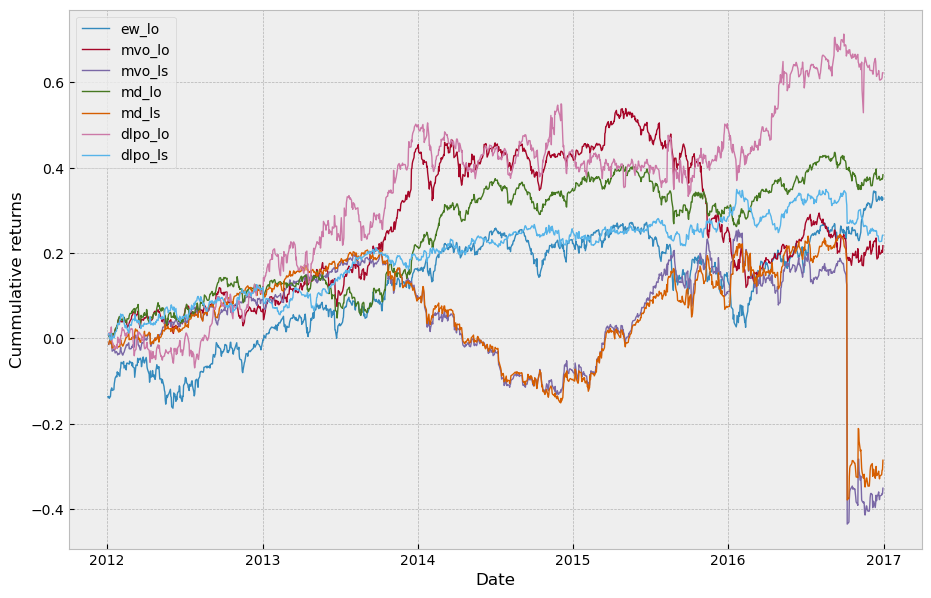

In [15]:

fig, ax = plt.subplots(figsize=(11, 7))
for model in model_names:
    summary_df = all_summary_df.loc[all_summary_df["model"] == model]
    cum_pnl_df = summary_df.groupby("date").sum()[["pnl"]].cumsum().loc["2012-01-01":].reset_index()
    ax.plot(pd.to_datetime(cum_pnl_df['date']), cum_pnl_df["pnl"], label=model)

plt.xlabel("Date")
plt.ylabel("Cummulative returns")
plt.legend(loc='best', fontsize=10)   
# fig.savefig('img/' + ticker + '_' + key1 + '_fs_methods.png')
plt.show()

## 3) Boxplot with the Sharpe Ratio for each Monte Carlo Sample

## 4) Forecast Comparison - Diebold-Mariano Test